# Libor Curve Bootstrapper

The goal of the project is to build a bootstrapping procedure whose output will be a forward libor curve in the “multi-curve” framework. The input parameters to derive this curve are:

* the par rate of a set of Overnight Index Swaps (i.e. their market quotation);
* the fixing value of the libor rate at the “evaluation date”;
* the par rate of a set of swaps (i.e. their market quotation), whose underlying libor rate has 6 months tenor and the fixed coupon is paid annually.

# Note and Hints

Numerical results must be presented to the examining committee during a presentation in which the candidates will also explain the theoretical framework for multi-curve evaluation.

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/Projects')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import date

today = date(2019, 10, 31)
libor_tenor = 6
libor_fixing_value = 0.00351

ois_quotes = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/ois_quotes.csv")
irs_quotes = pd.read_csv("https://raw.githubusercontent.com/matteosan1/finance_course/develop/Projects/irs_quotes_proj6.csv")

In [ ]:
from finmarkets import OvernightIndexSwap

pillar_dates = [today]
swaps = []
for q in range(len(ois_quotes)):
    swaps.append(OvernightIndexSwap(1, today, 
                                    ois_quotes.loc[q, 'quote']*0.01, 
                                    ois_quotes.loc[q, 'months']))
    pillar_dates.append(swaps[-1].payment_dates[-1])

print (pillar_dates)

[datetime.date(2019, 10, 31), datetime.date(2019, 11, 30), datetime.date(2019, 12, 31), datetime.date(2020, 1, 31), datetime.date(2020, 2, 29), datetime.date(2020, 3, 31), datetime.date(2020, 4, 30), datetime.date(2020, 5, 31), datetime.date(2020, 6, 30), datetime.date(2020, 7, 31), datetime.date(2020, 8, 31), datetime.date(2020, 9, 30), datetime.date(2020, 10, 31), datetime.date(2021, 4, 30), datetime.date(2022, 4, 30), datetime.date(2022, 10, 31), datetime.date(2023, 10, 31), datetime.date(2024, 10, 31), datetime.date(2025, 10, 31), datetime.date(2026, 10, 31), datetime.date(2027, 10, 31), datetime.date(2028, 10, 31), datetime.date(2029, 10, 31), datetime.date(2030, 10, 31), datetime.date(2031, 10, 31), datetime.date(2034, 10, 31), datetime.date(2039, 10, 31), datetime.date(2044, 10, 31), datetime.date(2049, 10, 31), datetime.date(2054, 10, 31), datetime.date(2059, 10, 31), datetime.date(2069, 10, 31)]


In [ ]:
from finmarkets import DiscountCurve

def obj_func(x):
    curve = DiscountCurve(pillar_dates, x)
    
    npv = 0 
    for s in swaps:
        npv += s.npv(curve)**2
        
    return npv

In [ ]:
from scipy.optimize import minimize

x0 = [0.5 for _ in range(len(pillar_dates))]
bounds = [(0.01, 10.) for _ in range(len(pillar_dates))]
bounds[0] = (1, 1)

result = minimize(obj_func, x0, bounds=bounds)

In [ ]:
print (result)
print (obj_func(x0))
print (result.fun)

      fun: 5.070930858430352e-15
 hess_inv: <32x32 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.22585735e-07, -1.14950700e-08, -1.22461748e-08, -1.25221657e-08,
       -1.23763441e-08, -1.18229058e-08, -1.09390918e-08, -9.70588367e-09,
       -8.24985403e-09, -6.52677601e-09, -4.64081649e-09, -2.70048767e-09,
        1.81449376e-08,  3.62092497e-09,  4.67793040e-09,  1.28193283e-08,
        1.06934286e-08,  8.50481934e-09,  6.29401833e-09,  4.73726261e-09,
        4.38650712e-09,  6.03280150e-09,  1.01932259e-08,  1.73042070e-08,
        1.63504404e-08,  2.05106918e-08,  2.61822288e-08,  3.10152632e-08,
        1.87419144e-08,  6.51292673e-09, -4.04760348e-08, -1.02824363e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 264
      nit: 5
   status: 0
  success: True
        x: array([1.        , 1.00040399, 1.00082111, 1.00123969, 1.00162942,
       1.00204561, 1.00244424, 1.00285343, 1.00324509, 1.00364368,
       1.00403373, 1.00440408, 1

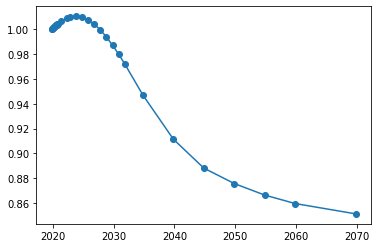

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pillar_dates, result.x, marker='o')
plt.show()

In [ ]:
discount_curve = DiscountCurve(pillar_dates, result.x)

In [ ]:
from finmarkets import InterestRateSwap, ForwardRateCurve
from dateutil.relativedelta import relativedelta

irs = []
libor_pillar_dates = [today]
for i, swap in irs_quotes.iterrows():
  irs.append(InterestRateSwap(1, today, 
                              swap['rate'], libor_tenor, 
                              int(swap['maturity']/12)))
  libor_pillar_dates.append(today + relativedelta(months=swap['maturity']))
    
libor_pillar_dates = sorted(libor_pillar_dates)

In [ ]:
def libor_obj_func(x):
  libor_curve = ForwardRateCurve(libor_pillar_dates, x)
    
  npv = 0
  for i in irs:
    npv += i.npv(discount_curve, libor_curve)**2
    
  return npv

In [ ]:
fwd0 = [0.01 for _ in range(len(libor_pillar_dates))]
fwd_bounds = [(-100, 100) for _ in range(len(libor_pillar_dates))]
fwd_bounds[0] = (libor_fixing_value, libor_fixing_value)

fwd_result = minimize(libor_obj_func, fwd0, bounds=fwd_bounds)

In [ ]:
print (fwd_result)
print (libor_obj_func(fwd0))
print (libor_obj_func(fwd_result.x))

      fun: 1.1878473289217561e-08
 hess_inv: <34x34 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.14890297e-07,  4.70330484e-05,  2.04768692e-04,  4.89123689e-04,
        1.38856134e-04,  1.22184316e-04, -9.06346742e-05,  4.45308123e-05,
        1.13402816e-04, -6.05592635e-05, -1.82880077e-04, -6.10996811e-05,
        1.30314013e-04, -4.28687538e-04, -1.78523128e-04,  5.15205721e-04,
       -2.19509169e-04,  1.94087004e-05,  3.59863569e-05,  4.44689312e-06,
        7.50779008e-06,  1.11131829e-05,  1.11143668e-05,  1.13405149e-05,
        1.20815471e-05,  1.22686618e-05,  1.24063313e-05,  1.27873658e-05,
        2.64393714e-05,  1.20093352e-05,  1.37163141e-04, -7.54828416e-04,
        7.24776835e-04,  2.48575910e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2555
      nit: 67
   status: 0
  success: True
        x: array([0.00351   , 0.00369594, 0.00487217, 0.00649871, 0.00862287,
       0.01084176, 0.01294002, 0.01485015, 0.01655577, 0

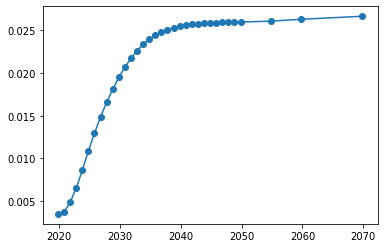

In [ ]:
from datetime import date
fwd_curve =  ForwardRateCurve(libor_pillar_dates, fwd_result.x)

from matplotlib import pyplot as plt
plt.plot(libor_pillar_dates, fwd_curve.rates, marker='o')
plt.show()
